In [1]:
import numpy as np

In [2]:
data = open("HP1_paragraph.txt").read().lower()

In [3]:
words = data.split()
len(words)

4651

In [4]:
split_index = int(0.8 * len(words))

train_data = words[:split_index]
test_data = words[split_index:]

In [5]:
len(set(train_data)-set(test_data))

1076

In [6]:
len(set(test_data)-set(train_data))

271

In [7]:
word_set = set(words)
word_set
word_to_idx = {w:i for i, w in enumerate(word_set)}
idx_to_word = {i:w for i, w in enumerate(word_set)}

In [8]:
word_size = len(word_set)
word_size

1573

In [9]:
def oneHotEncode(text):
    output = np.zeros((word_size, 1))
    output[word_to_idx[text]] = 1

    return output

# Xavier Normalized Initialization
def initWeights(input_size, output_size):
    return np.random.uniform(-1, 1, (output_size, input_size)) * np.sqrt(6 / (input_size + output_size))

##### Activation Functions #####
def sigmoid(input, derivative = False):
    if derivative:
        return input * (1 - input)

    return 1 / (1 + np.exp(-input))

def tanh(input, derivative = False):
    if derivative:
        return 1 - input ** 2

    return np.tanh(input)

def softmax(input):
    return np.exp(input) / np.sum(np.exp(input))

##### Long Short-Term Memory Network Class #####
class LSTM:
    def __init__(self, input_size, hidden_size, output_size, num_epochs, learning_rate):
        # Hyperparameters
        self.learning_rate = learning_rate
        self.hidden_size = hidden_size
        self.num_epochs = num_epochs

        # Forget Gate
        self.wf = initWeights(input_size, hidden_size)
        self.bf = np.zeros((hidden_size, 1))

        # Input Gate
        self.wi = initWeights(input_size, hidden_size)
        self.bi = np.zeros((hidden_size, 1))

        # Candidate Gate
        self.wc = initWeights(input_size, hidden_size)
        self.bc = np.zeros((hidden_size, 1))

        # Output Gate
        self.wo = initWeights(input_size, hidden_size)
        self.bo = np.zeros((hidden_size, 1))

        # Final Gate
        self.wy = initWeights(hidden_size, output_size)
        self.by = np.zeros((output_size, 1))

    # Reset Network Memory
    def reset(self):
        self.concat_inputs = {}

        self.hidden_states = {-1:np.zeros((self.hidden_size, 1))}
        self.cell_states = {-1:np.zeros((self.hidden_size, 1))}

        self.activation_outputs = {}
        self.candidate_gates = {}
        self.output_gates = {}
        self.forget_gates = {}
        self.input_gates = {}
        self.outputs = {}

    # Forward Propogation
    def forward(self, inputs):
        self.reset()

        outputs = []
        for q in range(len(inputs)):
            self.concat_inputs[q] = np.concatenate((self.hidden_states[q - 1], inputs[q]))

            self.forget_gates[q] = sigmoid(np.dot(self.wf, self.concat_inputs[q]) + self.bf)
            self.input_gates[q] = sigmoid(np.dot(self.wi, self.concat_inputs[q]) + self.bi)
            self.candidate_gates[q] = tanh(np.dot(self.wc, self.concat_inputs[q]) + self.bc)
            self.output_gates[q] = sigmoid(np.dot(self.wo, self.concat_inputs[q]) + self.bo)

            self.cell_states[q] = self.forget_gates[q] * self.cell_states[q - 1] + self.input_gates[q] * self.candidate_gates[q]
            self.hidden_states[q] = self.output_gates[q] * tanh(self.cell_states[q])

            outputs += [np.dot(self.wy, self.hidden_states[q]) + self.by]

        return outputs

    # Backward Propogation
    def backward(self, errors, inputs):
        d_wf, d_bf = 0, 0
        d_wi, d_bi = 0, 0
        d_wc, d_bc = 0, 0
        d_wo, d_bo = 0, 0
        d_wy, d_by = 0, 0

        dh_next, dc_next = np.zeros_like(self.hidden_states[0]), np.zeros_like(self.cell_states[0])
        for q in reversed(range(len(inputs))):
            error = errors[q]

            # Final Gate Weights and Biases Errors
            d_wy += np.dot(error, self.hidden_states[q].T)
            d_by += error

            # Hidden State Error
            d_hs = np.dot(self.wy.T, error) + dh_next

            # Output Gate Weights and Biases Errors
            d_o = tanh(self.cell_states[q]) * d_hs * sigmoid(self.output_gates[q], derivative = True)
            d_wo += np.dot(d_o, inputs[q].T)
            d_bo += d_o

            # Cell State Error
            d_cs = tanh(tanh(self.cell_states[q]), derivative = True) * self.output_gates[q] * d_hs + dc_next

            # Forget Gate Weights and Biases Errors
            d_f = d_cs * self.cell_states[q - 1] * sigmoid(self.forget_gates[q], derivative = True)
            d_wf += np.dot(d_f, inputs[q].T)
            d_bf += d_f

            # Input Gate Weights and Biases Errors
            d_i = d_cs * self.candidate_gates[q] * sigmoid(self.input_gates[q], derivative = True)
            d_wi += np.dot(d_i, inputs[q].T)
            d_bi += d_i

            # Candidate Gate Weights and Biases Errors
            d_c = d_cs * self.input_gates[q] * tanh(self.candidate_gates[q], derivative = True)
            d_wc += np.dot(d_c, inputs[q].T)
            d_bc += d_c

            # Concatenated Input Error (Sum of Error at Each Gate!)
            d_z = np.dot(self.wf.T, d_f) + np.dot(self.wi.T, d_i) + np.dot(self.wc.T, d_c) + np.dot(self.wo.T, d_o)

            # Error of Hidden State and Cell State at Next Time Step
            dh_next = d_z[:self.hidden_size, :]
            dc_next = self.forget_gates[q] * d_cs

        for d_ in (d_wf, d_bf, d_wi, d_bi, d_wc, d_bc, d_wo, d_bo, d_wy, d_by):
            np.clip(d_, -1, 1, out = d_)

        self.wf += d_wf * self.learning_rate
        self.bf += d_bf * self.learning_rate

        self.wi += d_wi * self.learning_rate
        self.bi += d_bi * self.learning_rate

        self.wc += d_wc * self.learning_rate
        self.bc += d_bc * self.learning_rate

        self.wo += d_wo * self.learning_rate
        self.bo += d_bo * self.learning_rate

        self.wy += d_wy * self.learning_rate
        self.by += d_by * self.learning_rate

    # Train
    def train(self, inputs, labels):
        inputs = [oneHotEncode(input) for input in inputs]

        loss = []
        average_loss = []
        accuracy_list = []

        for _ in range(self.num_epochs):
            predictions = self.forward(inputs)

            errors = []
            l = 0
            accuracy = 0
            for q in range(len(predictions)):
                errors += [-softmax(predictions[q])]
                errors[-1][word_to_idx[labels[q]]] += 1

                l += -np.log(softmax(predictions[q])[word_to_idx[labels[q]]])

                prediction = str(idx_to_word[np.random.choice([*range(word_size)], p = softmax(predictions[q].reshape(-1)))])
                if prediction == labels[q]:
                    accuracy += 1

            loss.append(l)
            average_loss.append(l/len(predictions))
            accuracy_list.append((accuracy/len(labels))*100)

            if (_ == 0) | ((_+1)%20==0):
                print(f"Epoch: {_+1}, Loss: {loss[_]}, Average Loss: {average_loss[_]}, Accuracy: {accuracy_list[_]} \n")

            self.backward(errors, self.concat_inputs)

        return loss, average_loss, accuracy_list

    # Test
    def test(self, inputs, labels):
        accuracy = 0
        predictions = self.forward([oneHotEncode(input) for input in inputs])

        output = []
        for q in range(len(labels)):
            prediction = str(idx_to_word[np.random.choice([*range(word_size)], p = softmax(predictions[q].reshape(-1)))])

            output.append(prediction)

            if prediction == labels[q]:
                accuracy += 1

        print(f'Ground Truth:\nt{labels}\n')
        print(f'Predictions:\nt{output}\n')

        print(f'Accuracy: {round(accuracy * 100 / len(labels), 2)}%')

In [10]:
# Initialize Network
hidden_size = 25
lstm = LSTM(input_size = word_size + hidden_size, hidden_size = hidden_size, output_size = word_size, num_epochs = 500, learning_rate = 0.1)

##### Training #####
train_X, train_y = train_data[:-1], train_data[1:]
train_loss_sum, train_loss_mean, train_accuracy = lstm.train(train_X, train_y)

Epoch: 1, Loss: [27374.73014499], Average Loss: [7.36077713], Accuracy: 0.08066684592632428 

Epoch: 20, Loss: [25917.68817896], Average Loss: [6.96899386], Accuracy: 2.339338531863404 

Epoch: 40, Loss: [23094.79399404], Average Loss: [6.2099473], Accuracy: 1.8822264049475665 

Epoch: 60, Loss: [19420.95510077], Average Loss: [5.22209064], Accuracy: 3.6031191180424846 

Epoch: 80, Loss: [16411.29639372], Average Loss: [4.41282506], Accuracy: 4.329120731379403 

Epoch: 100, Loss: [13333.50195039], Average Loss: [3.58523849], Accuracy: 6.184458187684862 

Epoch: 120, Loss: [10635.23309427], Average Loss: [2.85970236], Accuracy: 12.610916913148696 

Epoch: 140, Loss: [8866.60848943], Average Loss: [2.3841378], Accuracy: 19.118042484538854 

Epoch: 160, Loss: [7699.33317622], Average Loss: [2.07026974], Accuracy: 22.45227211616026 

Epoch: 180, Loss: [6659.19920529], Average Loss: [1.79058865], Accuracy: 32.13229362731917 

Epoch: 200, Loss: [6041.98209391], Average Loss: [1.62462546], Ac

In [11]:
lstm.test(train_data[:-1], train_data[1:])

Ground Truth:
t['potter', 'and', 'the', "sorcerer's", 'stone', 'chapter', 'one', 'the', 'boy', 'who', 'lived', 'mr.', 'and', 'mrs.', 'dursley,', 'of', 'number', 'four,', 'privet', 'drive,', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal,', 'thank', 'you', 'very', 'much.', 'they', 'were', 'the', 'last', 'people', "you'd", 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious,', 'because', 'they', 'just', "didn't", 'hold', 'with', 'such', 'nonsense.', 'mr.', 'dursley', 'was', 'the', 'director', 'of', 'a', 'firm', 'called', 'grunnings,', 'which', 'made', 'drills.', 'he', 'was', 'a', 'big,', 'beefy', 'man', 'with', 'hardly', 'any', 'neck,', 'although', 'he', 'did', 'have', 'a', 'very', 'large', 'mustache.', 'mrs.', 'dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck,', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so', 'much', 'of', 'her', 'time', 'craning'

In [12]:
test_X, test_y = test_data[:-1], test_data[1:]
lstm.test(test_X, test_y)

Ground Truth:
t['eyed', 'his', 'cloak', 'suddenly', 'as', 'though', 'she', 'thought', 'he', 'might', 'be', 'hiding', 'harry', 'underneath', 'it.', '"hagrid\'s', 'bringing', 'him."', '"you', 'think', 'it', '--', 'wise', '--', 'to', 'trust', 'hagrid', 'with', 'something', 'as', 'important', 'as', 'this?"', 'i', 'would', 'trust', 'hagrid', 'with', 'my', 'life,"', 'said', 'dumbledore.', '"i\'m', 'not', 'saying', 'his', 'heart', "isn't", 'in', 'the', 'right', 'place,"', 'said', 'professor', 'mcgonagall', 'grudgingly,', '"but', 'you', "can't", 'pretend', "he's", 'not', 'careless.', 'he', 'does', 'tend', 'to', '--', 'what', 'was', 'that?"', 'a', 'low', 'rumbling', 'sound', 'had', 'broken', 'the', 'silence', 'around', 'them.', 'it', 'grew', 'steadily', 'louder', 'as', 'they', 'looked', 'up', 'and', 'down', 'the', 'street', 'for', 'some', 'sign', 'of', 'a', 'headlight;', 'it', 'swelled', 'to', 'a', 'roar', 'as', 'they', 'both', 'looked', 'up', 'at', 'the', 'sky', '--', 'and', 'a', 'huge', 'moto

Text(0, 0.5, 'training loss')

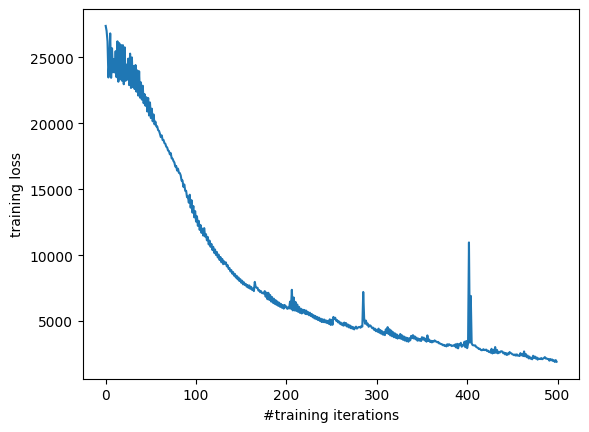

In [13]:
import pylab as plt

plt.plot([i for i in range(len(train_loss_sum))], train_loss_sum)
plt.xlabel("#training iterations")
plt.ylabel("training loss")

Text(0, 0.5, 'mean training loss')

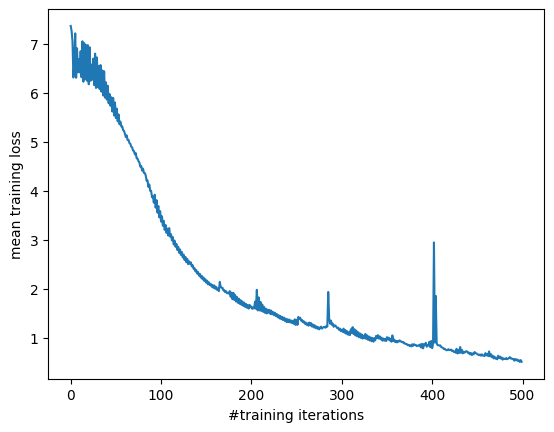

In [14]:
plt.plot([i for i in range(len(train_loss_mean))], train_loss_mean)
plt.xlabel("#training iterations")
plt.ylabel("mean training loss")

In [15]:
import random
train_data_shuffled = np.copy(train_data)
random.shuffle(train_data_shuffled)

lstm.test(train_data_shuffled[:-1], train_data_shuffled[1:])

Ground Truth:
t['thought' 'daylight,' 'they' ... 'people' 'and' 'it']

Predictions:
t['yawned', 'with', 'though', 'reached', 'his', 'dursley.', 'his', 'instead,', 'quiver', 'to', 'had', 'and', "he'd", 'on', 'of', 'past', 'but', 'still', 'the', 'night', "that's", 'he', 'he', 'was', 'in', 'back', 'hugged', 'reached', 'trick', 'collecting', 'boots.', 'nasty,', 'would', 'professor,', 'word', 'it', 'them', 'i', 'next', 'age', 'saw', 'dressed', 'missed,', 'outside', 'fixed', 'her', 'a', 'even', 'with', 'as', 'two', 'same,', 'rather', "he'd", 'at', 'the', 'his', 'ground.', 'drive,', 'trying', 'on', 'might', 'of', 'mind', 'of', 'off', 'and', 'eleven', 'down', 'last,', 'even', "that's", 'his', 'purple', 'celebrate', 'window', 'were', 'is', 'looking', 'here,', 'dudley', 'live', 'and', 'tiny', 'that', 'notice.', 'think', 'his', 'all,', 'his', 'can', 'wife.', 'it', 'had', 'seemed', 'talk!', 'i', 'were', "didn't", 'have', 'window.', 'number', 'and', 'name.', 'the', 'that', 'very', 'in', 'shooting',

In [16]:
# Initialize Network
hidden_size = 25
lstm = LSTM(input_size = word_size + hidden_size, hidden_size = hidden_size, output_size = word_size, num_epochs = 1000, learning_rate = 0.1)

##### Training #####
train_X, train_y = train_data[:-1], train_data[1:]
train_loss_sum, train_loss_mean, train_accuracy = lstm.train(train_X, train_y)

Epoch: 1, Loss: [27374.73663213], Average Loss: [7.36077887], Accuracy: 0.10755579456843238 

Epoch: 20, Loss: [25980.76429262], Average Loss: [6.98595437], Accuracy: 2.1242269427265392 

Epoch: 40, Loss: [23655.18588976], Average Loss: [6.36063079], Accuracy: 2.070449045442323 

Epoch: 60, Loss: [19731.61154112], Average Loss: [5.30562289], Accuracy: 3.2804517343371873 

Epoch: 80, Loss: [16691.28494015], Average Loss: [4.48811104], Accuracy: 5.055122344716321 

Epoch: 100, Loss: [14485.09297148], Average Loss: [3.89488921], Accuracy: 7.313794030653402 

Epoch: 120, Loss: [12573.5198286], Average Loss: [3.38088729], Accuracy: 8.927130949179887 

Epoch: 140, Loss: [11117.50663574], Average Loss: [2.98938065], Accuracy: 12.637805861790804 

Epoch: 160, Loss: [9895.8024738], Average Loss: [2.66087724], Accuracy: 16.80559290131756 

Epoch: 180, Loss: [8916.00549923], Average Loss: [2.39742014], Accuracy: 20.16671148158107 

Epoch: 200, Loss: [8191.36478104], Average Loss: [2.20257187], Ac

In [17]:
lstm.test(train_data[:-1], train_data[1:])

Ground Truth:
t['potter', 'and', 'the', "sorcerer's", 'stone', 'chapter', 'one', 'the', 'boy', 'who', 'lived', 'mr.', 'and', 'mrs.', 'dursley,', 'of', 'number', 'four,', 'privet', 'drive,', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal,', 'thank', 'you', 'very', 'much.', 'they', 'were', 'the', 'last', 'people', "you'd", 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious,', 'because', 'they', 'just', "didn't", 'hold', 'with', 'such', 'nonsense.', 'mr.', 'dursley', 'was', 'the', 'director', 'of', 'a', 'firm', 'called', 'grunnings,', 'which', 'made', 'drills.', 'he', 'was', 'a', 'big,', 'beefy', 'man', 'with', 'hardly', 'any', 'neck,', 'although', 'he', 'did', 'have', 'a', 'very', 'large', 'mustache.', 'mrs.', 'dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck,', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so', 'much', 'of', 'her', 'time', 'craning'

In [18]:
test_X, test_y = test_data[:-1], test_data[1:]
lstm.test(test_X, test_y)

Ground Truth:
t['eyed', 'his', 'cloak', 'suddenly', 'as', 'though', 'she', 'thought', 'he', 'might', 'be', 'hiding', 'harry', 'underneath', 'it.', '"hagrid\'s', 'bringing', 'him."', '"you', 'think', 'it', '--', 'wise', '--', 'to', 'trust', 'hagrid', 'with', 'something', 'as', 'important', 'as', 'this?"', 'i', 'would', 'trust', 'hagrid', 'with', 'my', 'life,"', 'said', 'dumbledore.', '"i\'m', 'not', 'saying', 'his', 'heart', "isn't", 'in', 'the', 'right', 'place,"', 'said', 'professor', 'mcgonagall', 'grudgingly,', '"but', 'you', "can't", 'pretend', "he's", 'not', 'careless.', 'he', 'does', 'tend', 'to', '--', 'what', 'was', 'that?"', 'a', 'low', 'rumbling', 'sound', 'had', 'broken', 'the', 'silence', 'around', 'them.', 'it', 'grew', 'steadily', 'louder', 'as', 'they', 'looked', 'up', 'and', 'down', 'the', 'street', 'for', 'some', 'sign', 'of', 'a', 'headlight;', 'it', 'swelled', 'to', 'a', 'roar', 'as', 'they', 'both', 'looked', 'up', 'at', 'the', 'sky', '--', 'and', 'a', 'huge', 'moto

Text(0, 0.5, 'training loss')

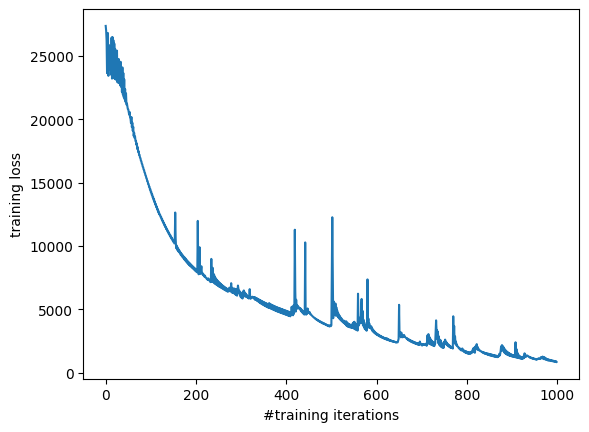

In [19]:
import pylab as plt

plt.plot([i for i in range(len(train_loss_sum))], train_loss_sum)
plt.xlabel("#training iterations")
plt.ylabel("training loss")

Text(0, 0.5, 'mean training loss')

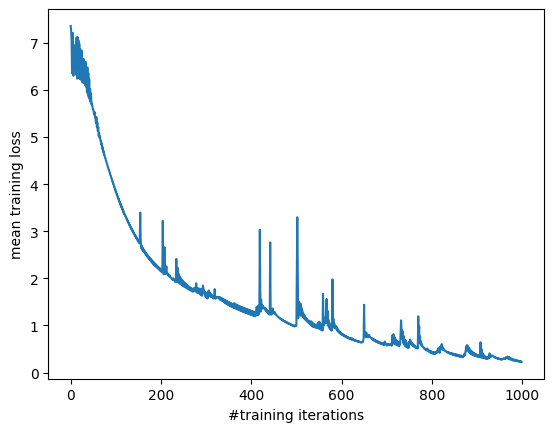

In [20]:
plt.plot([i for i in range(len(train_loss_mean))], train_loss_mean)
plt.xlabel("#training iterations")
plt.ylabel("mean training loss")

In [21]:
import random
test_data_shuffled = np.copy(test_data)
random.shuffle(test_data_shuffled)

lstm.test(test_data_shuffled[:-1], test_data_shuffled[1:])

Ground Truth:
t['"borrowed' 'pretend' 'trust' 'i' 'street' 'landed' 'as' 'a' 'in'
 'happen.' 'the' 'silver' 'like' 'the' 'before' 'simply' 'did' 'time'
 'least' 'hissed' 'map' 'the' 'were' 'into' 'him' 'street.' 'in'
 "c-c-can't" 'sounding' 'took' 'give' 'he' 'potter' 'scars' 'hagrid'
 'boy,' '-' 'out' 'the' 'spoke.' '--' 'turned' 'have' 'jacket' 'i' 'off'
 'minute' 'meeting' '"good' 'times' 'underneath' 'over' 'other' 'had'
 'hushed' 'to' 'handkerchief' 'roar' 'street.' 'hand' 'we' 'face'
 'gingerly' 'saying' 'out.' 'there?"' 'shoulders' 'tuft' 'to' 'and' 'in'
 'her' '"but' 'dumbledore' 'professor' 'life;' 'huge' 'something' 'around'
 'silence' 'gone.' 'down' 'and' 'motorcycle?"' 'to' 'i' 'not' '"could'
 'mcgonagall' 'the' "g'night," '"he\'ll' 'a' 'big' 'started' 'small'
 'they' 'would' 'himself' "an'" "he's" 'dumbledore?"' 'clicked' 'his'
 'very' 'if' 'she' 'wild' 'as' 'you' 'sit,"' 'her.' 'almost' 'professor'
 'beside' 'well' 'under' 'normal' 'his' 'professor' "dumbledore's" 'with'


In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
data = open("HP1_paragraph.txt").read().lower()

In [23]:
def word_count(paragraph):
  word_count = 0
  for i in range(len(paragraph)):
      if paragraph[i] == ' ' or paragraph[i] == '\n':
        word_count += 1
  return word_count

In [24]:
chars = set(data)
data_size, char_size = len(data), len(chars)
print(f'Data size: {data_size}, Char Size: {char_size}')
print(data[:10])
word_count_data = word_count(data)
print(f'word_count_data = {word_count_data}')

Data size: 26113, Char Size: 40
harry pott
word_count_data = 4893


In [25]:
split_index = int(0.8 * len(data))

while data[split_index] != ' ' and data[split_index] != '\n':
  split_index += 1

train_data = data[:split_index]
test_data = data[split_index:]

print(f'Training data size: {len(train_data)}, Training char size: {len(set(train_data))}')
print(f'Test data size: {len(test_data)}, Test char size: {len(set(test_data))}')

word_count_train = word_count(train_data)
word_count_test = word_count(test_data)
print(f'word_count_train = {word_count_train}')
print(f'word_count_test = {word_count_test}')

print(f'train_data = {train_data}')
print(f'test_data = {test_data}')

Training data size: 20896, Training char size: 40
Test data size: 5217, Test char size: 36
word_count_train = 3912
word_count_test = 981
train_data = harry potter and the sorcerer's stone 

chapter one 

the boy who lived 

mr. and mrs. dursley, of number four, privet drive, were proud to say that they were perfectly normal, thank you very much. they were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense. 

mr. dursley was the director of a firm called grunnings, which made drills. he was a big, beefy man with hardly any neck, although he did have a very large mustache. mrs. dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. the dursleys had a small son called dudley and in their opinion there was no finer boy anywhere. 

the dursleys had everything they wanted, but they also

In [26]:
# Sample paragraph
paragraph = train_data

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([paragraph])
total_words = len(tokenizer.word_index) + 1

# Create input sequences using list of tokens
input_sequences = []
for line in paragraph.split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Pad sequences to ensure uniform length
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create predictors and label
X, y = input_sequences[:,:-1],input_sequences[:,-1]

# Define the LSTM model
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(LSTM(100))
model.add(Dense(total_words, activation='softmax'))

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit model
model.fit(X, y, epochs=100, verbose=1)


Epoch 1/100
114/114 [==============================] - 19s 141ms/step - loss: 6.3756 - accuracy: 0.0392
Epoch 2/100
114/114 [==============================] - 16s 142ms/step - loss: 5.9551 - accuracy: 0.0428
Epoch 3/100
114/114 [==============================] - 16s 143ms/step - loss: 5.8225 - accuracy: 0.0431
Epoch 4/100
114/114 [==============================] - 16s 140ms/step - loss: 5.7321 - accuracy: 0.0453
Epoch 5/100
114/114 [==============================] - 16s 141ms/step - loss: 5.6461 - accuracy: 0.0588
Epoch 6/100
114/114 [==============================] - 16s 137ms/step - loss: 5.5439 - accuracy: 0.0754
Epoch 7/100
114/114 [==============================] - 16s 144ms/step - loss: 5.4222 - accuracy: 0.0820
Epoch 8/100
114/114 [==============================] - 18s 154ms/step - loss: 5.3017 - accuracy: 0.0883
Epoch 9/100
114/114 [==============================] - 16s 141ms/step - loss: 5.1808 - accuracy: 0.0994
Epoch 10/100
114/114 [==============================] - 16s 139m

In [27]:
# Function to generate text given a seed text
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)[0]
        predicted_index = np.argmax(predicted_probs)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

# Generate text
first_word_index = 1
while test_data[first_word_index] != ' ' and test_data[first_word_index] != '\n':
  first_word_index += 1
test_paragraph = test_data[:first_word_index]
print(f'test_paragraph = {test_paragraph}')
generated_text = generate_text(test_paragraph, word_count_test, model, max_sequence_len)
print(generated_text)


test_paragraph =  she
 she threw a sharp sideways glance at dumbledore here as though hoping he was going to tell her something but he didn't so she went on a fine thing it would be if on the very day youknow who seems to have disappeared at last the muggles found out about us all i suppose he really has gone dumbledore we have much to be thankful for would you care for a lemon drop and did not answer they had never even seen him this boy was another good reason for keeping the potters away they didn't want dudley mixing with a child like that swept the ground the cat's tail twitched and its eyes narrowed have been hundreds of sightings of these birds flying in every direction since sunrise experts are unable to explain why the owls have suddenly changed their sleeping pattern the newscaster allowed himself a grin of the cat was still there was a big beefy man with hardly ever been hundreds of sightings of these birds flying in every direction since sunrise kiss in went last night earl

In [28]:
# Function to generate text given a seed text
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)[0]
        predicted_index = np.argmax(predicted_probs)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
    return output_word

# Generate text
first_word_index = 1
while test_data[first_word_index] != ' ' and test_data[first_word_index] != '\n':
  first_word_index += 1
test_paragraph = test_data.split()[:-1]
print(f'test_paragraph = {test_paragraph}')
generated_text = test_data[:first_word_index]
for text in test_paragraph:
  word = generate_text(text, 1, model, max_sequence_len)
  generated_text += " " + word

print(generated_text)


test_paragraph = ['she', 'thought', 'he', 'might', 'be', 'hiding', 'harry', 'underneath', 'it.', '"hagrid\'s', 'bringing', 'him."', '"you', 'think', 'it', '--', 'wise', '--', 'to', 'trust', 'hagrid', 'with', 'something', 'as', 'important', 'as', 'this?"', 'i', 'would', 'trust', 'hagrid', 'with', 'my', 'life,"', 'said', 'dumbledore.', '"i\'m', 'not', 'saying', 'his', 'heart', "isn't", 'in', 'the', 'right', 'place,"', 'said', 'professor', 'mcgonagall', 'grudgingly,', '"but', 'you', "can't", 'pretend', "he's", 'not', 'careless.', 'he', 'does', 'tend', 'to', '--', 'what', 'was', 'that?"', 'a', 'low', 'rumbling', 'sound', 'had', 'broken', 'the', 'silence', 'around', 'them.', 'it', 'grew', 'steadily', 'louder', 'as', 'they', 'looked', 'up', 'and', 'down', 'the', 'street', 'for', 'some', 'sign', 'of', 'a', 'headlight;', 'it', 'swelled', 'to', 'a', 'roar', 'as', 'they', 'both', 'looked', 'up', 'at', 'the', 'sky', '--', 'and', 'a', 'huge', 'motorcycle', 'fell', 'out', 'of', 'the', 'air', 'and',

In [29]:
#calculate accuracy by char
print(f'len(test_data) = {len(test_data)}')
print(f'len(generated_text) = {len(generated_text)}\n')
min_len = min(len(test_data), len(generated_text))

print(f'test_data = {test_data}\n')
print(type(test_data))
print(f'generated_text = {generated_text}')
print(generated_text)
match_count = 0
for i in range(min_len):
  if test_data[i] == generated_text[i]:
    match_count += 1
accuracy = match_count / min_len
print(f'accuracy = {round(accuracy * 100, 2)}%')

len(test_data) = 5217
len(generated_text) = 5265

test_data =  she thought he might be hiding harry underneath it. 

"hagrid's bringing him." 

"you think it -- wise -- to trust hagrid with something as important as this?" 

i would trust hagrid with my life," said dumbledore. 

"i'm not saying his heart isn't in the right place," said professor mcgonagall grudgingly, "but you can't pretend he's not careless. he does tend to -- what was that?" 

a low rumbling sound had broken the silence around them. it grew steadily louder as they looked up and down the street for some sign of a headlight; it swelled to a roar as they both looked up at the sky -- and a huge motorcycle fell out of the air and landed on the road in front of them. 

if the motorcycle was huge, it was nothing to the man sitting astride it. he was almost twice as tall as a normal man and at least five times as wide. he looked simply too big to be allowed, and so wild - long tangles of bushy black hair and beard hid most o

In [30]:
#calculate accuracy by char
print(f'len(test_data) = {len(test_data)}')
print(f'len(generated_text) = {len(generated_text)}\n')
min_len = min(len(test_data), len(generated_text))

test_data_list = test_data.split()
generated_text_list = generated_text.split()
min_len_list = min(len(test_data_list), len(generated_text_list))

print(f'test_data_list = {test_data_list}\n')
print(f'generated_text_list = {generated_text_list}')

print(f'test_data = {test_data}\n')
print(f'generated_text = {generated_text}')

match_count = 0
for i in range(min_len):
  if test_data[i] == generated_text[i]:
    match_count += 1
accuracy = match_count / min_len

match_count_word = 0
for i in range(min_len_list):
  if test_data_list[i] == generated_text_list[i]:
    match_count_word += 1
accuracy_1 = match_count_word / min_len_list

print(f'accuracy letter = {round(accuracy * 100, 2)}%')
print(f'accuracy word = {round(accuracy_1 * 100, 2)}%')

len(test_data) = 5217
len(generated_text) = 5265

test_data_list = ['she', 'thought', 'he', 'might', 'be', 'hiding', 'harry', 'underneath', 'it.', '"hagrid\'s', 'bringing', 'him."', '"you', 'think', 'it', '--', 'wise', '--', 'to', 'trust', 'hagrid', 'with', 'something', 'as', 'important', 'as', 'this?"', 'i', 'would', 'trust', 'hagrid', 'with', 'my', 'life,"', 'said', 'dumbledore.', '"i\'m', 'not', 'saying', 'his', 'heart', "isn't", 'in', 'the', 'right', 'place,"', 'said', 'professor', 'mcgonagall', 'grudgingly,', '"but', 'you', "can't", 'pretend', "he's", 'not', 'careless.', 'he', 'does', 'tend', 'to', '--', 'what', 'was', 'that?"', 'a', 'low', 'rumbling', 'sound', 'had', 'broken', 'the', 'silence', 'around', 'them.', 'it', 'grew', 'steadily', 'louder', 'as', 'they', 'looked', 'up', 'and', 'down', 'the', 'street', 'for', 'some', 'sign', 'of', 'a', 'headlight;', 'it', 'swelled', 'to', 'a', 'roar', 'as', 'they', 'both', 'looked', 'up', 'at', 'the', 'sky', '--', 'and', 'a', 'huge', 'moto

In [42]:
import random
print(type(test_data))
test_data_shuffled = test_data.split()
random.shuffle(test_data_shuffled)
print(test_data_shuffled)
# Generate text
test_paragraph = test_data_shuffled[:-1]
print(f'test_paragraph = {test_paragraph}')
generated_text = test_data_shuffled[0]
for text in test_paragraph:
  word = generate_text(text, 1, model, max_sequence_len)
  #print(word)
  generated_text += " " + word

print(generated_text)
#calculate accuracy by char
print(f'len(test_data) = {len(test_data)}')
print(f'len(generated_text) = {len(generated_text)}\n')
min_len = min(len(test_data), len(generated_text))

test_data_list = test_data.split()
generated_text_list = generated_text.split()
min_len_list = min(len(test_data_list), len(generated_text_list))

print(f'test_data_list = {test_data_list}\n')
print(f'generated_text_list = {generated_text_list}')

print(f'test_data = {test_data}\n')
print(f'generated_text = {generated_text}')

match_count = 0
for i in range(min_len):
  if test_data[i] == generated_text[i]:
    match_count += 1
accuracy = match_count / min_len

match_count_word = 0
for i in range(min_len_list):
  if test_data_list[i] == generated_text_list[i]:
    match_count_word += 1
accuracy_1 = match_count_word / min_len_list

print(f'accuracy letter = {round(accuracy * 100, 2)}%')
print(f'accuracy word = {round(accuracy_1 * 100, 2)}%')

<class 'str'>
['reply.', 'heel', 'up.', 'like', 'and', 'his', 'walked', 'of', 'you', 'lightning.', 'looked', 'out', 'the', 'his', 'to', 'minute', 'the', 'lent', 'milk', 'neat', 'looked', 'at', 'he', 'spend', 'and', 'that.', 'over', 'down', 'and', 'hedges', '"even', 'eyes', 'knowing', 'scar', 'special,', 'of', 'mcgonagall', 'destroyed,', 'bristol."', 'a', 'james', 'we', 'i', 'a', 'as', 'up', 'a', 'well', 'end', 'in', 'a', 'to', 'inside,', 'was', '"i', 'hagrid', 'mcgonagall', 'blankets', 'spotted', 'boy', 'we', 'heart', 'happen.', 'see', 'glasses', 'a', 'huge', 'he', 'from', 'around.', 'was', 'fell', 'right', 'onto', 'a', 'as', 'and', 'and', 'cousin', 'front', 'things', 'nodding', 'holding', '--', 'sir?"', 'fast', 'them', 'a', 'careless.', 'drive,', 'without', 'was', 'professor', "couldn't", 'had', 'his', 'as', 'said', 'asleep.', 'time', 'hagrid,', 'was', 'orange', 'up', 'back', 'came', 'very', 'black', 'started', '"couldn\'t', 'the', 'can', 'to', 'that', 'sir', 'their', 'roar', 'her.', 